#  📊 Exploratory Data Analysis and Visualization
# 
### **Purpose:** Comprehensive exploratory data analysis of stock data
# 
### **Dependencies:** `src/data.py`
# 
### **Key Functions Used:**
- `load_raw_data()` - Load previously downloaded data
- `calculate_returns()` - Calculate stock returns
- `align_timestamps()` - Align data across multiple stocks

In [1]:
# Setup and Imports
import os
import sys
import warnings
from datetime import datetime, timedelta
from scipy import stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Add project root to Python path
project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.data import load_raw_data, calculate_returns, align_timestamps

warnings.filterwarnings('ignore')

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

print("✅ Imports complete - using existing src/data.py functions")

✅ Imports complete - using existing src/data.py functions


## 1. Data Loading and Initial Setup

In [2]:
# Load data that was already downloaded in notebook 01
tickers = ['AAPL', 'GOOGL', 'MSFT', 'TSLA', 'AMZN']
stock_data = {}
failed_tickers = []

print("📥 Loading stock data...")
for ticker in tickers:
    try:
        data = load_raw_data(f'../data/raw/{ticker}.csv')
        stock_data[ticker] = data
        print(f"✅ Loaded {ticker}: {data.shape[0]} records")
    except Exception as e:
        print(f"❌ Failed to load {ticker}: {str(e)}")
        failed_tickers.append(ticker)

# Remove failed tickers
tickers = [t for t in tickers if t not in failed_tickers]

print(f"\n📊 Successfully loaded {len(stock_data)} stocks for EDA analysis")

# Align timestamps across all stocks
if len(stock_data) > 1:
    try:
        aligned_data = align_timestamps(list(stock_data.values()))
        # Update stock_data with aligned data
        for i, ticker in enumerate(tickers):
            stock_data[ticker] = aligned_data[i]
        print("✅ Timestamps aligned across all stocks")
    except Exception as e:
        print(f"⚠️ Timestamp alignment failed: {e}")
        print("Continuing with original data...")

📥 Loading stock data...
✅ Loaded AAPL: 1423 records
✅ Loaded GOOGL: 1423 records
✅ Loaded MSFT: 1423 records
✅ Loaded TSLA: 1423 records
✅ Loaded AMZN: 1423 records

📊 Successfully loaded 5 stocks for EDA analysis
✅ Timestamps aligned across all stocks


## 2. Configuration Parameters

In [3]:
print("📋 Configuration Parameters")
print("=" * 50)

# Moving average windows
MA_SHORT = 20
MA_MEDIUM = 50
MA_LONG = 200

# Volatility calculation window
VOLATILITY_WINDOW = 30

# Risk-free rate (for Sharpe ratio)
RISK_FREE_RATE = 0.02  # 2% annual

# Analysis parameters
REGIME_QUANTILES = {'low': 0.25, 'high': 0.75}
VIX_PROXY_WINDOW = 30

print(f"✅ MA Windows: {MA_SHORT}, {MA_MEDIUM}, {MA_LONG}")
print(f"✅ Volatility Window: {VOLATILITY_WINDOW}")
print(f"✅ Risk-free Rate: {RISK_FREE_RATE}")
print(f"✅ Configuration loaded successfully")

📋 Configuration Parameters
✅ MA Windows: 20, 50, 200
✅ Volatility Window: 30
✅ Risk-free Rate: 0.02
✅ Configuration loaded successfully


## 3. Statistical Analysis

In [4]:
print("📊 STATISTICAL SUMMARY")
print("=" * 50)

def calculate_statistics(stock_data, ticker):
    """Calculate comprehensive statistics for a stock"""
    data = stock_data[ticker]
    returns = calculate_returns(data['Close'])
    
    # Basic statistics
    stats_dict = {
        'Mean_Price': data['Close'].mean(),
        'Std_Price': data['Close'].std(),
        'Min_Price': data['Close'].min(),
        'Max_Price': data['Close'].max(),
        'Mean_Return': returns.mean(),
        'Std_Return': returns.std(),
        'Skewness': returns.skew(),
        'Kurtosis': returns.kurtosis(),
        'Sharpe_Ratio': returns.mean() / returns.std() * np.sqrt(252) if returns.std() != 0 else 0,
        'Max_Drawdown': ((data['Close'] / data['Close'].expanding().max()) - 1).min()
    }
    
    # Additional risk metrics
    # Value at Risk (5% and 1%)
    stats_dict['VaR_5%'] = returns.quantile(0.05)
    stats_dict['VaR_1%'] = returns.quantile(0.01)
    
    # Conditional Value at Risk (Expected Shortfall)
    stats_dict['CVaR_5%'] = returns[returns <= stats_dict['VaR_5%']].mean()
    stats_dict['CVaR_1%'] = returns[returns <= stats_dict['VaR_1%']].mean()
    
    # Calmar Ratio (if max drawdown is not zero)
    annual_return = (data['Close'].iloc[-1] / 
                    data['Close'].iloc[0]) ** (252 / len(data)) - 1
    stats_dict['Calmar_Ratio'] = annual_return / \
        abs(stats_dict['Max_Drawdown']) if stats_dict['Max_Drawdown'] != 0 else 0
    
    # Sortino Ratio (downside deviation)
    downside_returns = returns[returns < 0]
    downside_std = downside_returns.std() if len(downside_returns) > 0 else 0
    stats_dict['Sortino_Ratio'] = returns.mean() / downside_std * \
        np.sqrt(252) if downside_std != 0 else 0
    
    return stats_dict

# Calculate enhanced statistics
enhanced_stats = {}
for ticker in tickers:
    enhanced_stats[ticker] = calculate_statistics(stock_data, ticker)

enhanced_df = pd.DataFrame(enhanced_stats).T

# Display key metrics in groups
print("\n🔹 Return & Risk Metrics:")
risk_cols = ['Mean_Return', 'Std_Return', 'Sharpe_Ratio', 'Sortino_Ratio', 'Calmar_Ratio']
print(enhanced_df[risk_cols].round(4))

print("\n🔹 Tail Risk Metrics:")
tail_cols = ['VaR_5%', 'VaR_1%', 'CVaR_5%', 'CVaR_1%', 'Max_Drawdown']
print(enhanced_df[tail_cols].round(4))

print("\n🔹 Distribution Properties:")
dist_cols = ['Skewness', 'Kurtosis']
print(enhanced_df[dist_cols].round(4))


📊 STATISTICAL SUMMARY

🔹 Return & Risk Metrics:
       Mean_Return  Std_Return  Sharpe_Ratio  Sortino_Ratio  Calmar_Ratio
AAPL        0.0010      0.0204        0.7985         1.1281        0.6857
GOOGL       0.0010      0.0205        0.7850         1.0990        0.5052
MSFT        0.0010      0.0190        0.8565         1.2013        0.6367
TSLA        0.0026      0.0426        0.9804         1.4930        0.7394
AMZN        0.0009      0.0227        0.6138         0.8954        0.3007

🔹 Tail Risk Metrics:
       VaR_5%  VaR_1%  CVaR_5%  CVaR_1%  Max_Drawdown
AAPL  -0.0314 -0.0514  -0.0453  -0.0720       -0.3336
GOOGL -0.0320 -0.0536  -0.0468  -0.0718       -0.4432
MSFT  -0.0283 -0.0455  -0.0420  -0.0666       -0.3715
TSLA  -0.0627 -0.1152  -0.0912  -0.1420       -0.7363
AMZN  -0.0331 -0.0562  -0.0505  -0.0797       -0.5615

🔹 Distribution Properties:
       Skewness  Kurtosis
AAPL     0.2823    6.6507
GOOGL   -0.0640    3.5698
MSFT     0.1046    7.3498
TSLA     0.2490    3.2857
AMZN

## 4. Risk-Return Visualization

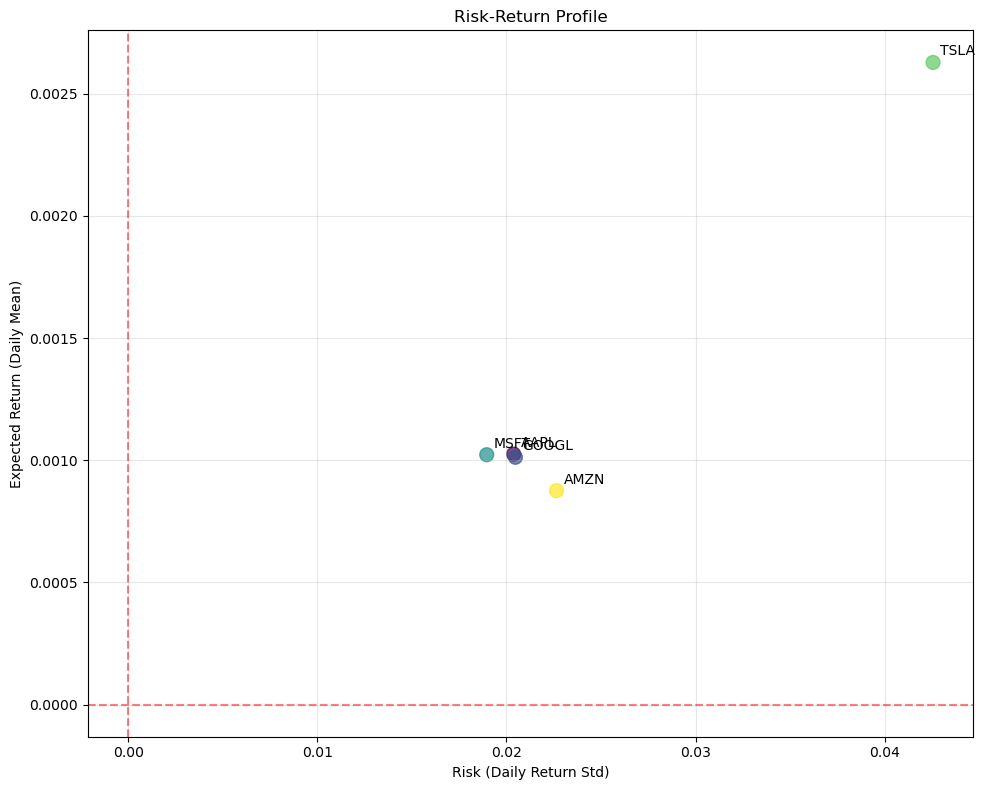

In [5]:
# Risk-return scatter plot
fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(enhanced_df['Std_Return'], enhanced_df['Mean_Return'],
                    s=100, alpha=0.7, c=range(len(tickers)), cmap='viridis')

# Add labels for each point
for i, ticker in enumerate(tickers):
    ax.annotate(ticker,
                (enhanced_df.loc[ticker, 'Std_Return'],
                 enhanced_df.loc[ticker, 'Mean_Return']),
                xytext=(5, 5), textcoords='offset points')

ax.set_xlabel('Risk (Daily Return Std)')
ax.set_ylabel('Expected Return (Daily Mean)')
ax.set_title('Risk-Return Profile')
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax.axvline(x=0, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


## 5. Returns Distribution Analysis

📈 RETURNS DISTRIBUTION ANALYSIS


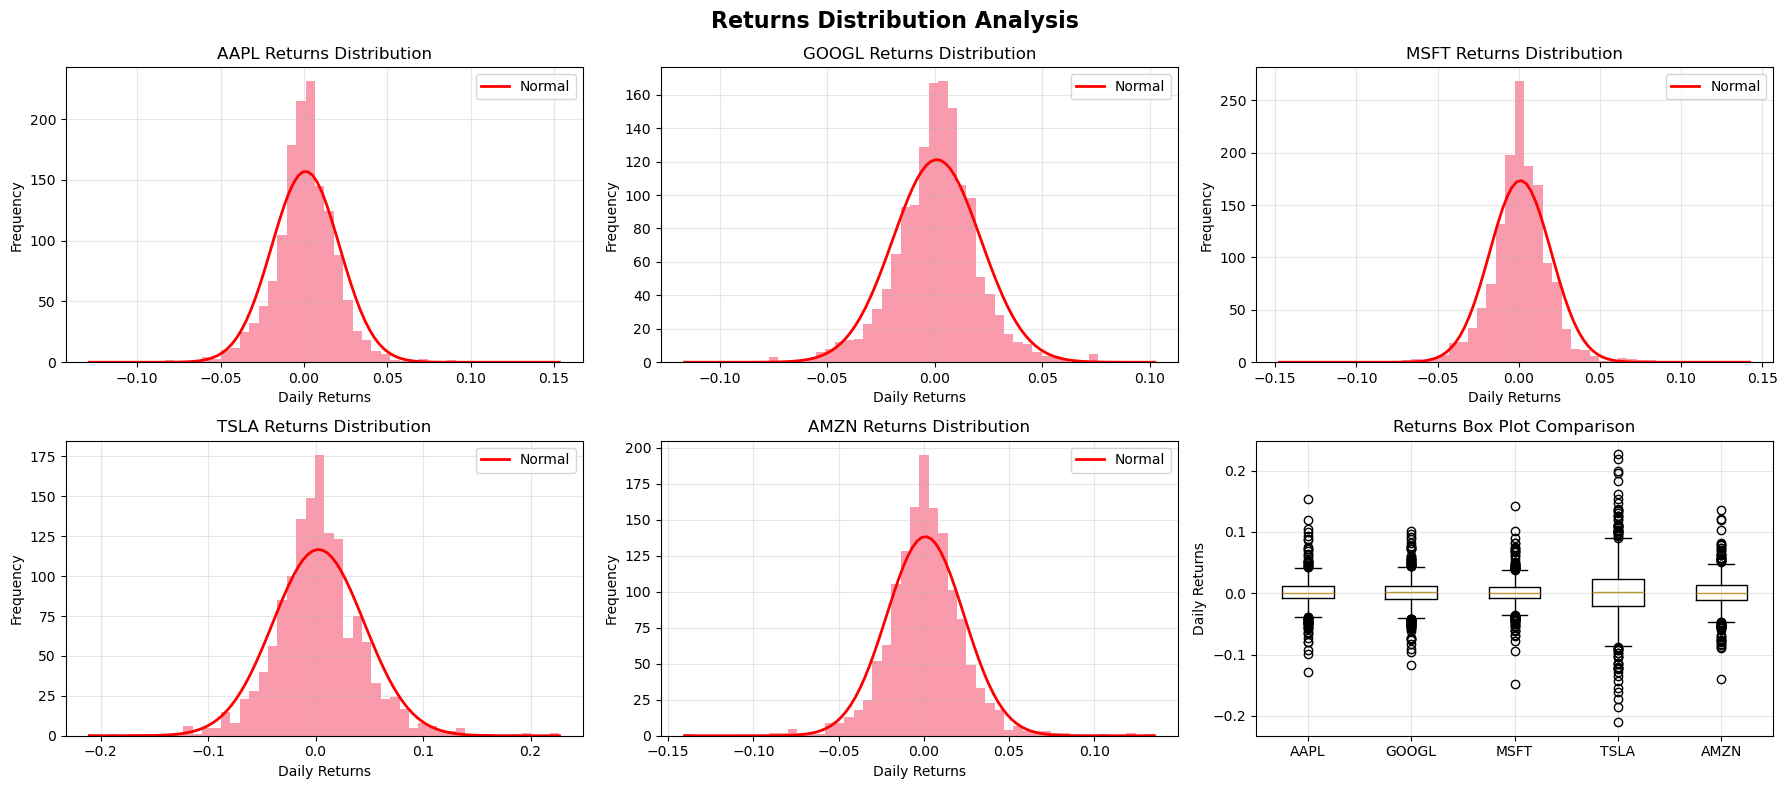


Normality Test Results (Shapiro-Wilk):
  AAPL: p-value=0.0000 (❌ Non-normal)
  GOOGL: p-value=0.0000 (❌ Non-normal)
  MSFT: p-value=0.0000 (❌ Non-normal)
  TSLA: p-value=0.0000 (❌ Non-normal)
  AMZN: p-value=0.0000 (❌ Non-normal)


In [6]:
print("📈 RETURNS DISTRIBUTION ANALYSIS")
print("=" * 50)

def calculate_subplot_grid(n_plots):
    """Calculate optimal grid dimensions for n plots"""
    if n_plots <= 3:
        return 1, n_plots
    elif n_plots <= 6:
        return 2, 3
    elif n_plots <= 9:
        return 3, 3
    else:
        rows = int(np.ceil(np.sqrt(n_plots)))
        cols = int(np.ceil(n_plots / rows))
        return rows, cols

# Calculate returns for all stocks
returns_data = {}
for ticker in tickers:
    returns_data[ticker] = calculate_returns(stock_data[ticker]['Close'])

returns_df = pd.DataFrame(returns_data)

# Create distribution analysis plot
n_tickers = len(tickers)
rows, cols = calculate_subplot_grid(n_tickers + 1)  # +1 for combined box plot
fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows))
fig.suptitle('Returns Distribution Analysis', fontsize=16, fontweight='bold')

# Flatten axes for easier indexing
if rows * cols > 1:
    axes_flat = axes.flatten() if rows > 1 else axes
else:
    axes_flat = [axes]

# Individual histograms
for i, ticker in enumerate(tickers):
    ax = axes_flat[i]
    
    returns_data[ticker].hist(bins=50, alpha=0.7, ax=ax)
    ax.set_title(f'{ticker} Returns Distribution')
    ax.set_xlabel('Daily Returns')
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3)
    
    # Add normal distribution overlay
    mu, sigma = returns_data[ticker].mean(), returns_data[ticker].std()
    x = np.linspace(returns_data[ticker].min(), returns_data[ticker].max(), 100)
    n, bins, patches = ax.hist(returns_data[ticker].dropna(), bins=50, alpha=0)
    bin_width = bins[1] - bins[0]
    total_area = len(returns_data[ticker]) * bin_width
    normal_curve = stats.norm.pdf(x, mu, sigma) * total_area
    ax.plot(x, normal_curve, 'r-', linewidth=2, label='Normal')
    ax.legend()

# Combined box plot
box_plot_idx = len(tickers)
if box_plot_idx < len(axes_flat):
    ax_box = axes_flat[box_plot_idx]
    ax_box.boxplot([returns_data[ticker].dropna() for ticker in tickers], 
                   labels=tickers)
    ax_box.set_title('Returns Box Plot Comparison')
    ax_box.set_ylabel('Daily Returns')
    ax_box.grid(True, alpha=0.3)

# Hide unused subplots
for i in range(len(tickers) + 1, len(axes_flat)):
    axes_flat[i].set_visible(False)

plt.tight_layout()
plt.show()

# Normality tests
print("\nNormality Test Results (Shapiro-Wilk):")
for ticker in tickers:
    clean_returns = returns_data[ticker].dropna()
    sample_size = min(5000, len(clean_returns))
    
    if sample_size > 0:
        sample = clean_returns.sample(sample_size)
        stat, p_value = stats.shapiro(sample)
        normal = "✅ Normal" if p_value > 0.05 else "❌ Non-normal"
        print(f"  {ticker}: p-value={p_value:.4f} ({normal})")
    else:
        print(f"  {ticker}: ⚠️ Not enough data to perform normality test.")

## 6. Correlation Analysis

🔗 CORRELATION ANALYSIS


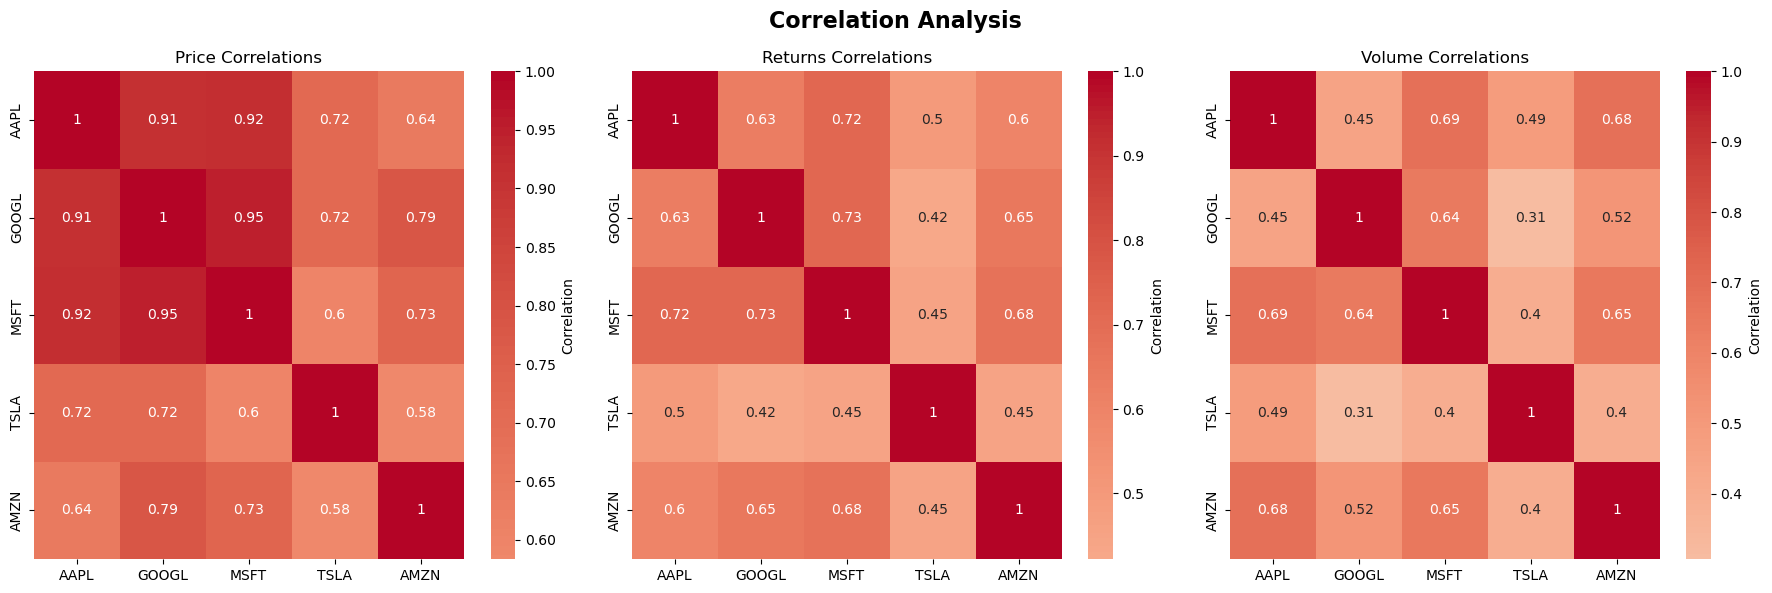

Highest Returns Correlations:
  GOOGL - MSFT: 0.726
  AAPL - MSFT: 0.722
  MSFT - AMZN: 0.678


In [7]:
print("🔗 CORRELATION ANALYSIS")
print("=" * 50)

# Price correlations
price_df = pd.DataFrame({ticker: stock_data[ticker]['Close'] for ticker in tickers})
price_corr = price_df.corr()

# Returns correlations
returns_corr = returns_df.corr()

# Volume correlations
volume_df = pd.DataFrame({ticker: stock_data[ticker]['Volume'] for ticker in tickers})
volume_corr = volume_df.corr()

# Create correlation heatmaps
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Correlation Analysis', fontsize=16, fontweight='bold')

# Price correlations
sns.heatmap(price_corr, annot=True, cmap='coolwarm', center=0,
            ax=axes[0], cbar_kws={'label': 'Correlation'})
axes[0].set_title('Price Correlations')

# Returns correlations
sns.heatmap(returns_corr, annot=True, cmap='coolwarm', center=0,
            ax=axes[1], cbar_kws={'label': 'Correlation'})
axes[1].set_title('Returns Correlations')

# Volume correlations
sns.heatmap(volume_corr, annot=True, cmap='coolwarm', center=0,
            ax=axes[2], cbar_kws={'label': 'Correlation'})
axes[2].set_title('Volume Correlations')

plt.tight_layout()
plt.show()

# Print highest correlations
print("Highest Returns Correlations:")
returns_corr_flat = returns_corr.where(
    np.triu(np.ones(returns_corr.shape), k=1).astype(bool))
high_corr = returns_corr_flat.stack().sort_values(ascending=False)
for pair, corr in high_corr.head(3).items():
    print(f"  {pair[0]} - {pair[1]}: {corr:.3f}")


## 7. Trend Analysis with Moving Averages

📊 TREND ANALYSIS


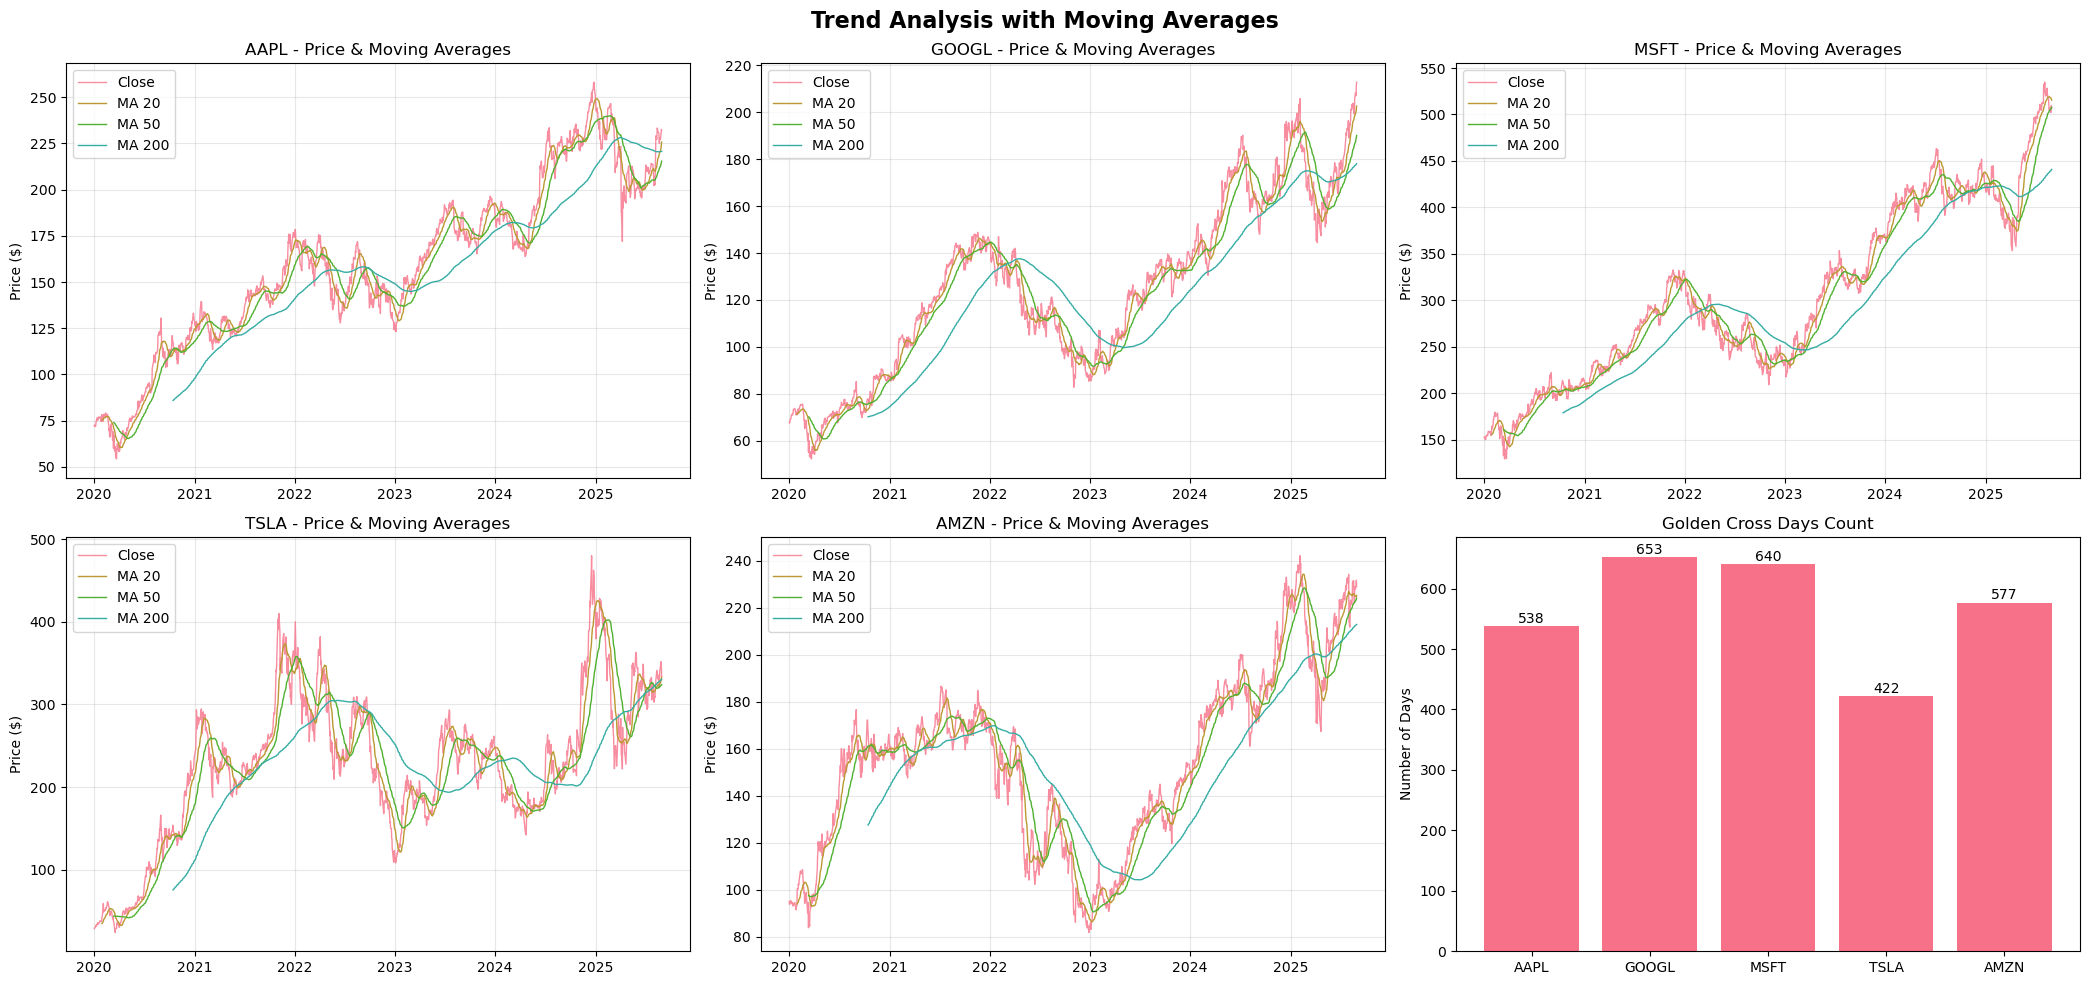

Current Trend Status:
  AAPL: 🔴 Bearish (MA20: $225.70, MA50: $215.38)
  GOOGL: 🟢 Bullish (MA20: $202.56, MA50: $190.03)
  MSFT: 🟢 Bullish (MA20: $515.39, MA50: $507.64)
  TSLA: 🔴 Bearish (MA20: $332.57, MA50: $323.79)
  AMZN: 🟢 Bullish (MA20: $225.17, MA50: $223.99)


In [8]:
print("📊 TREND ANALYSIS")
print("=" * 50)

# Calculate moving averages and trends
trend_data = {}
for ticker in tickers:
    data = stock_data[ticker].copy()
    
    # Moving averages
    data[f'MA_{MA_SHORT}'] = data['Close'].rolling(MA_SHORT).mean()
    data[f'MA_{MA_MEDIUM}'] = data['Close'].rolling(MA_MEDIUM).mean()
    data[f'MA_{MA_LONG}'] = data['Close'].rolling(MA_LONG).mean()
    
    # Trend indicators
    data['Trend_20_50'] = data[f'MA_{MA_SHORT}'] > data[f'MA_{MA_MEDIUM}']
    data['Trend_50_200'] = data[f'MA_{MA_MEDIUM}'] > data[f'MA_{MA_LONG}']
    data['Golden_Cross'] = data['Trend_20_50'] & data['Trend_50_200']
    
    trend_data[ticker] = data

# Trend analysis visualization
rows, cols = calculate_subplot_grid(len(tickers) + 1)  # +1 for golden cross chart
fig, axes = plt.subplots(rows, cols, figsize=(7*cols, 5*rows))
axes_flat = axes.flatten() if rows > 1 else ([axes] if cols == 1 else axes)

fig.suptitle('Trend Analysis with Moving Averages', fontsize=16, fontweight='bold')

for i, ticker in enumerate(tickers):
    ax = axes_flat[i]
    data = trend_data[ticker]
    
    # Plot prices and moving averages
    ax.plot(data.index, data['Close'], label='Close', linewidth=1, alpha=0.8)
    ax.plot(data.index, data[f'MA_{MA_SHORT}'], label=f'MA {MA_SHORT}', linewidth=1)
    ax.plot(data.index, data[f'MA_{MA_MEDIUM}'], label=f'MA {MA_MEDIUM}', linewidth=1)
    ax.plot(data.index, data[f'MA_{MA_LONG}'], label=f'MA {MA_LONG}', linewidth=1)
    
    ax.set_title(f'{ticker} - Price & Moving Averages')
    ax.set_ylabel('Price ($)')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Golden Cross analysis for last subplot
gc_idx = len(tickers)
if gc_idx < len(axes_flat):
    ax_gc = axes_flat[gc_idx]
    golden_cross_counts = {}
    for ticker in tickers:
        golden_cross_counts[ticker] = trend_data[ticker]['Golden_Cross'].sum()
    
    bars = ax_gc.bar(golden_cross_counts.keys(), golden_cross_counts.values())
    ax_gc.set_title('Golden Cross Days Count')
    ax_gc.set_ylabel('Number of Days')
    for bar, count in zip(bars, golden_cross_counts.values()):
        ax_gc.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                   str(count), ha='center')

# Hide unused subplots
for i in range(len(tickers) + 1, len(axes_flat)):
    axes_flat[i].set_visible(False)

plt.tight_layout()
plt.show()

# Print trend summary
print("Current Trend Status:")
for ticker in tickers:
    data = trend_data[ticker]
    latest = data.iloc[-1]
    trend_status = "🟢 Bullish" if latest['Golden_Cross'] else "🔴 Bearish"
    print(f"  {ticker}: {trend_status} (MA20: ${latest[f'MA_{MA_SHORT}']:.2f}, "
          f"MA50: ${latest[f'MA_{MA_MEDIUM}']:.2f})")

## 8. Volatility Analysis

⚡ VOLATILITY ANALYSIS


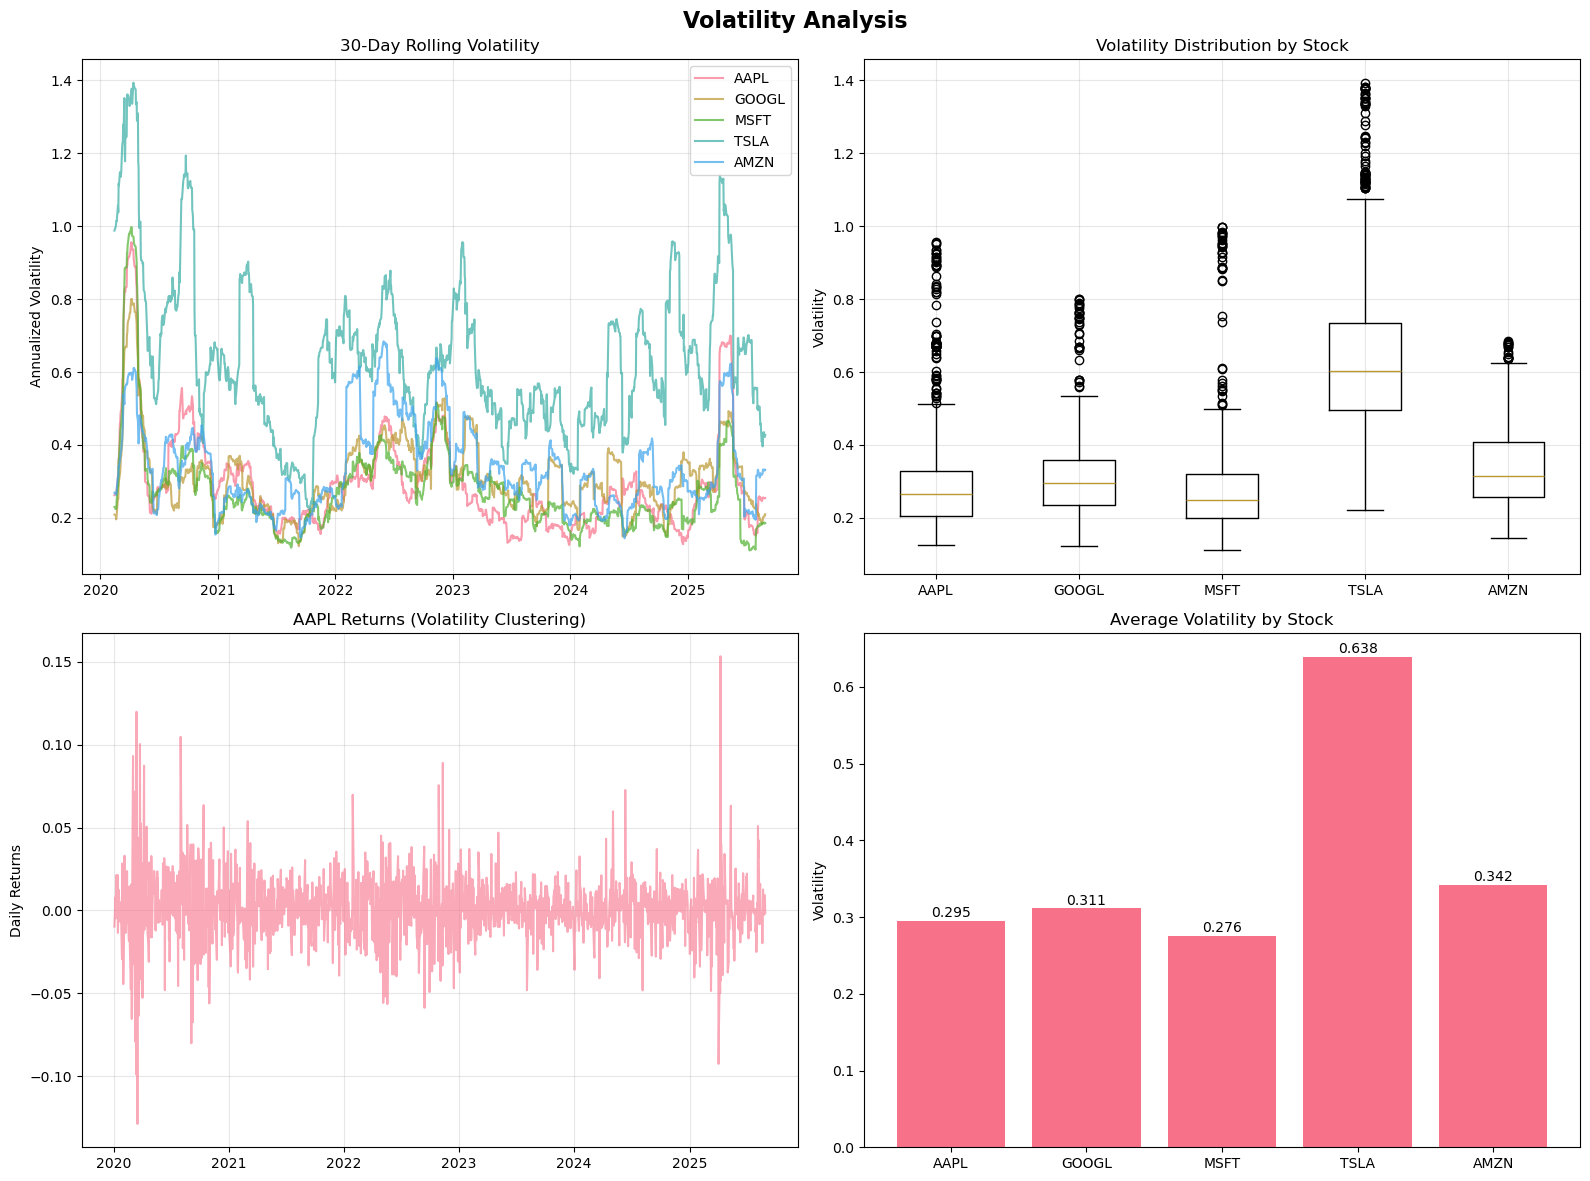

Volatility Rankings (30-day average):
  1. TSLA: 0.638
  2. AMZN: 0.342
  3. GOOGL: 0.311
  4. AAPL: 0.295
  5. MSFT: 0.276


In [9]:
print("⚡ VOLATILITY ANALYSIS")
print("=" * 50)

# Calculate different volatility measures
volatility_data = {}
for ticker in tickers:
    returns = calculate_returns(stock_data[ticker]['Close'])
    
    # Rolling volatility (30-day)
    rolling_vol = returns.rolling(30).std() * np.sqrt(252)
    
    # GARCH-like simple volatility clustering
    vol_clustering = returns.rolling(5).std()
    
    # High-low volatility (Garman-Klass estimator)
    high = stock_data[ticker]['High']
    low = stock_data[ticker]['Low']
    close = stock_data[ticker]['Close']
    open_price = stock_data[ticker]['Open']
    
    gk_vol = np.sqrt(0.5 * np.log(high/low)**2 - 
                     (2*np.log(2)-1) * np.log(close/open_price)**2)
    
    volatility_data[ticker] = {
        'returns': returns,
        'rolling_vol': rolling_vol,
        'vol_clustering': vol_clustering,
        'gk_vol': gk_vol
    }

# Volatility visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Volatility Analysis', fontsize=16, fontweight='bold')

# Rolling volatility comparison
for ticker in tickers:
    axes[0, 0].plot(volatility_data[ticker]['rolling_vol'].index,
                    volatility_data[ticker]['rolling_vol'],
                    label=ticker, alpha=0.7)

axes[0, 0].set_title('30-Day Rolling Volatility')
axes[0, 0].set_ylabel('Annualized Volatility')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Volatility distribution
vol_values = [volatility_data[ticker]['rolling_vol'].dropna() for ticker in tickers]
axes[0, 1].boxplot(vol_values, labels=tickers)
axes[0, 1].set_title('Volatility Distribution by Stock')
axes[0, 1].set_ylabel('Volatility')
axes[0, 1].grid(True, alpha=0.3)

# Volatility clustering example (first available ticker)
example_ticker = tickers[0]
example_returns = volatility_data[example_ticker]['returns']
axes[1, 0].plot(example_returns.index, example_returns, alpha=0.6)
axes[1, 0].set_title(f'{example_ticker} Returns (Volatility Clustering)')
axes[1, 0].set_ylabel('Daily Returns')
axes[1, 0].grid(True, alpha=0.3)

# Average volatility by stock
avg_vols = {ticker: volatility_data[ticker]['rolling_vol'].mean() for ticker in tickers}
bars = axes[1, 1].bar(avg_vols.keys(), avg_vols.values())
axes[1, 1].set_title('Average Volatility by Stock')
axes[1, 1].set_ylabel('Volatility')
for bar, vol in zip(bars, avg_vols.values()):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                    f'{vol:.3f}', ha='center')

plt.tight_layout()
plt.show()

# Volatility rankings
print("Volatility Rankings (30-day average):")
vol_ranking = sorted(avg_vols.items(), key=lambda x: x[1], reverse=True)
for i, (ticker, vol) in enumerate(vol_ranking, 1):
    print(f"  {i}. {ticker}: {vol:.3f}")

## 9. Market Regime Analysis

🔄 MARKET REGIME ANALYSIS


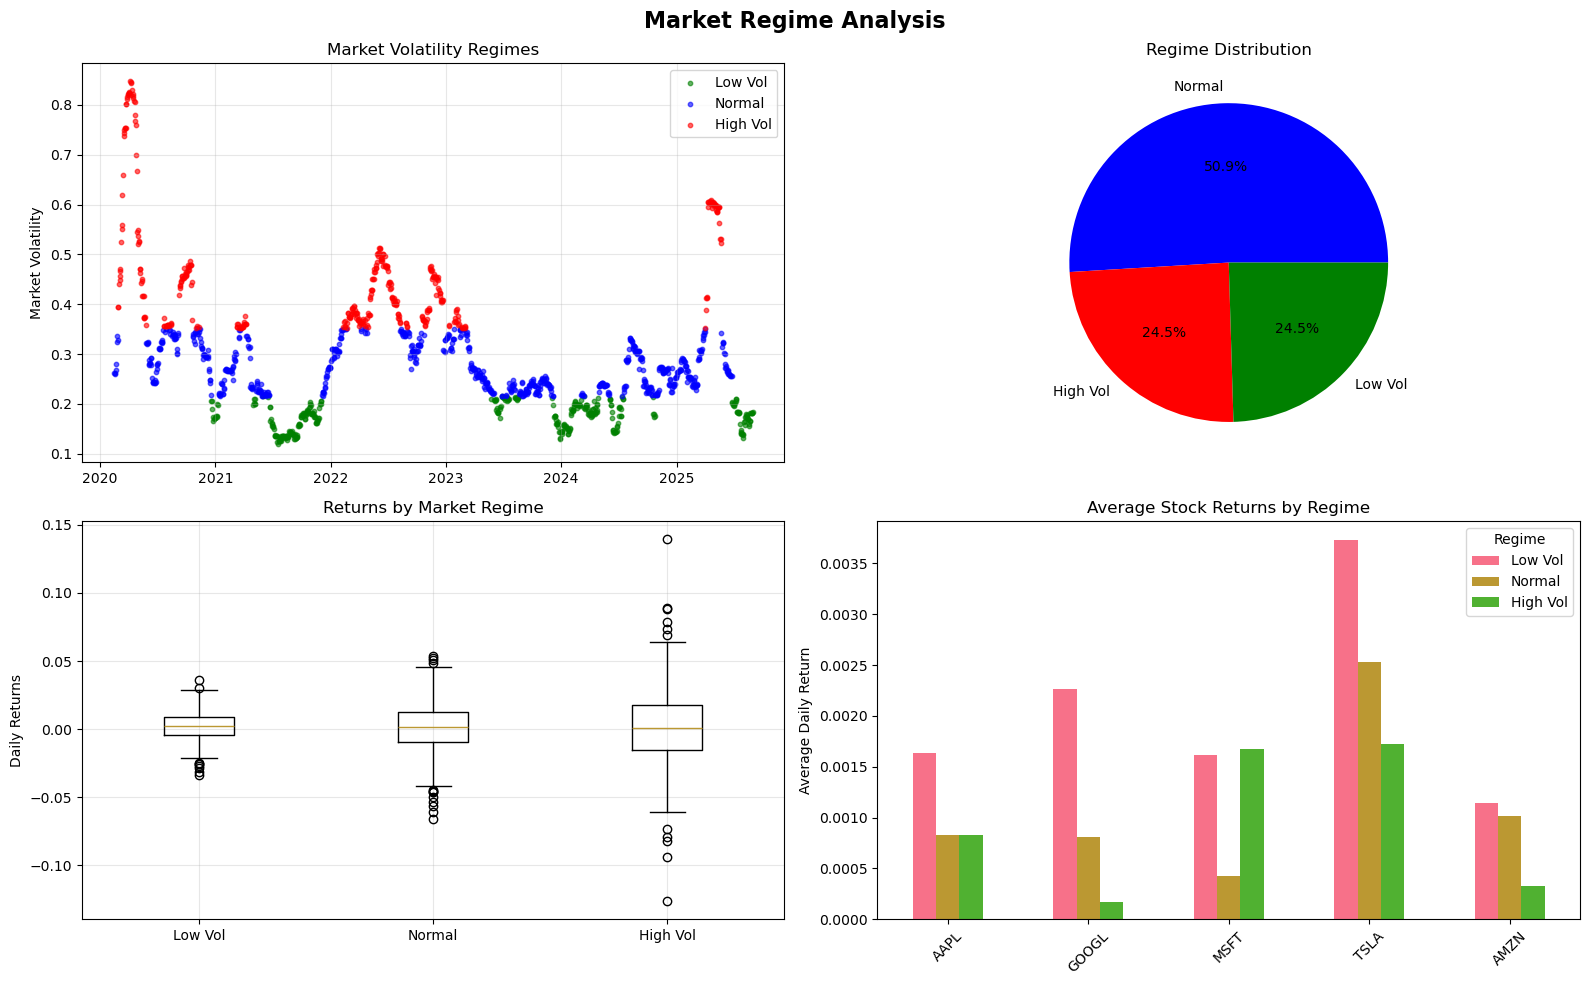

Average Returns by Market Regime:
  Low Vol: 0.0021
  Normal: 0.0011
  High Vol: 0.0009


In [10]:
print("🔄 MARKET REGIME ANALYSIS")
print("=" * 50)

# Calculate market-wide metrics
market_returns = returns_df.mean(axis=1)  # Equal-weighted market
market_vol = market_returns.rolling(30).std() * np.sqrt(252)

# Define regimes based on volatility quartiles
vol_q25 = market_vol.quantile(0.25)
vol_q75 = market_vol.quantile(0.75)

def get_regime(vol):
    if vol <= vol_q25:
        return 'Low Vol'
    elif vol >= vol_q75:
        return 'High Vol'
    else:
        return 'Normal'

market_regime = market_vol.apply(get_regime)

# Regime analysis visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Market Regime Analysis', fontsize=16, fontweight='bold')

# Market volatility with regime coloring
colors = {'Low Vol': 'green', 'Normal': 'blue', 'High Vol': 'red'}
for regime in ['Low Vol', 'Normal', 'High Vol']:
    mask = market_regime == regime
    axes[0, 0].scatter(market_vol[mask].index, market_vol[mask],
                       c=colors[regime], label=regime, alpha=0.6, s=10)

axes[0, 0].set_title('Market Volatility Regimes')
axes[0, 0].set_ylabel('Market Volatility')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Regime distribution
regime_counts = market_regime.value_counts()
axes[0, 1].pie(regime_counts.values, labels=regime_counts.index, autopct='%1.1f%%',
               colors=[colors[regime] for regime in regime_counts.index])
axes[0, 1].set_title('Regime Distribution')

# Returns by regime
regime_returns = {}
for regime in ['Low Vol', 'Normal', 'High Vol']:
    mask = market_regime == regime
    regime_returns[regime] = market_returns[mask]

axes[1, 0].boxplot([regime_returns[regime].dropna() for regime in ['Low Vol', 'Normal', 'High Vol']],
                   labels=['Low Vol', 'Normal', 'High Vol'])
axes[1, 0].set_title('Returns by Market Regime')
axes[1, 0].set_ylabel('Daily Returns')
axes[1, 0].grid(True, alpha=0.3)

# Stock performance by regime
regime_performance = {}
for ticker in tickers:
    ticker_returns = returns_data[ticker]
    perf = {}
    for regime in ['Low Vol', 'Normal', 'High Vol']:
        mask = market_regime == regime
        aligned_returns = ticker_returns.reindex(market_regime.index)
        perf[regime] = aligned_returns[mask].mean()
    regime_performance[ticker] = perf

perf_df = pd.DataFrame(regime_performance).T
perf_df.plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_title('Average Stock Returns by Regime')
axes[1, 1].set_ylabel('Average Daily Return')
axes[1, 1].legend(title='Regime')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("Average Returns by Market Regime:")
for regime in ['Low Vol', 'Normal', 'High Vol']:
    avg_return = market_returns[market_regime == regime].mean()
    print(f"  {regime}: {avg_return:.4f}")


## 10. Key Insights Summary

In [11]:
print("🎯 KEY INSIGHTS SUMMARY")
print("=" * 60)

print("1. STATISTICAL INSIGHTS:")
most_volatile = enhanced_df['Std_Return'].idxmax()
least_volatile = enhanced_df['Std_Return'].idxmin()
best_sharpe = enhanced_df['Sharpe_Ratio'].idxmax()
print(f"   • Most volatile: {most_volatile}")
print(f"   • Least volatile: {least_volatile}")
print(f"   • Best Sharpe ratio: {best_sharpe}")

print("\n2. CORRELATION INSIGHTS:")
highest_corr_pair = returns_corr_flat.stack().idxmax()
lowest_corr_pair = returns_corr_flat.stack().idxmin()
print(f"   • Highest correlation: {highest_corr_pair[0]}-{highest_corr_pair[1]}")
print(f"   • Lowest correlation: {lowest_corr_pair[0]}-{lowest_corr_pair[1]}")

print("\n3. TREND INSIGHTS:")
bullish_stocks = [
    ticker for ticker in tickers if trend_data[ticker].iloc[-1]['Golden_Cross']]
bearish_stocks = [
    ticker for ticker in tickers if not trend_data[ticker].iloc[-1]['Golden_Cross']]
print(f"   • Currently bullish: {bullish_stocks}")
print(f"   • Currently bearish: {bearish_stocks}")

print("\n4. VOLATILITY INSIGHTS:")
print(f"   • Highest average volatility: {vol_ranking[0][0]} ({vol_ranking[0][1]:.3f})")
print(f"   • Lowest average volatility: {vol_ranking[-1][0]} ({vol_ranking[-1][1]:.3f})")

print("\n5. REGIME INSIGHTS:")
current_regime = market_regime.iloc[-1]
high_vol_days = len(market_regime[market_regime == 'High Vol'])
print(f"   • Current market regime: {current_regime}")
print(f"   • Days in high volatility regime: {high_vol_days}")

print(f"\n📊 EDA Analysis Complete!")
print("=" * 60)
print("🎯 Next Steps:")
print("   1. ➡️  Proceed to 03_feature_engineering.ipynb")
print("   2. ➡️  Market insights identified for feature creation")
print("   3. ➡️  Correlation patterns discovered for model selection")

🎯 KEY INSIGHTS SUMMARY
1. STATISTICAL INSIGHTS:
   • Most volatile: TSLA
   • Least volatile: MSFT
   • Best Sharpe ratio: TSLA

2. CORRELATION INSIGHTS:
   • Highest correlation: GOOGL-MSFT
   • Lowest correlation: GOOGL-TSLA

3. TREND INSIGHTS:
   • Currently bullish: ['GOOGL', 'MSFT', 'AMZN']
   • Currently bearish: ['AAPL', 'TSLA']

4. VOLATILITY INSIGHTS:
   • Highest average volatility: TSLA (0.638)
   • Lowest average volatility: MSFT (0.276)

5. REGIME INSIGHTS:
   • Current market regime: Low Vol
   • Days in high volatility regime: 349

📊 EDA Analysis Complete!
🎯 Next Steps:
   1. ➡️  Proceed to 03_feature_engineering.ipynb
   2. ➡️  Market insights identified for feature creation
   3. ➡️  Correlation patterns discovered for model selection
